<a href="https://colab.research.google.com/github/vandana10/deeplearning-using-pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch custom datasets

We've used some datasets with PyTorch before..
But how do you get your own data into PyTorch
On way is: Custom datasets



### 0. Importing PyTorch and setting up device agnoatic code

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset

Food101 starts 101 diff classes of food.

Our dataset starts with 3 classes of food and 10% of images(75 praining and 25 testing)

why do this?
First small scale and  then increase when its necessary

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one..")
  image_path.mkdir(parents=True, exist_ok=True)

#Download pizza steak and sushi data
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza steak and sushi data..")
  f.write(request.content)

#Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data..")
  zip_ref.extractall(image_path)

#Remove zip file
!rm {data_path / "pizza_steak_sushi.zip"}


data/pizza_steak_sushi does not exist, creating one..
Unzipping data..


##2. Becoming one with the data

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [6]:
#Set up training and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###2.1 Visulizing and image

lets write some code to:
1. get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the time class name usinh pathlib.Path.parent.stem
4. Since we are working with images, lets open the image with python's PIL
5. We'll  then show the image and print metadata

data/pizza_steak_sushi/train/pizza/2291093.jpg
pizza
Image class is: pizza
Image height: 512
Image width: 512


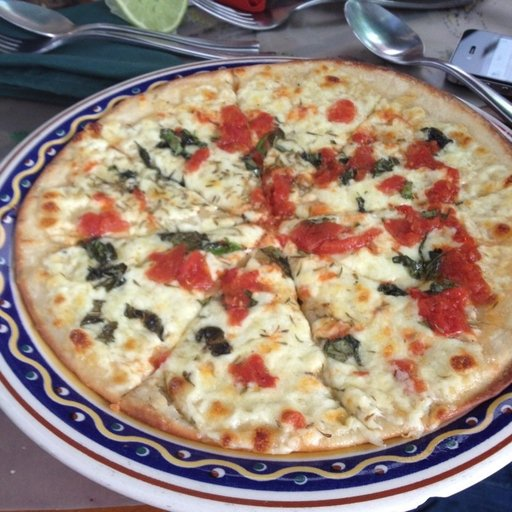

In [7]:
import random
from PIL import Image
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img =Image.open(random_image_path)

print(f"Image class is: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

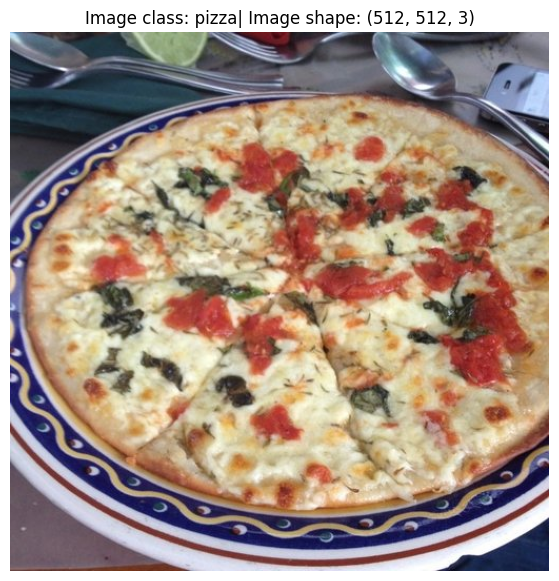

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}| Image shape: {img_as_array.shape}")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch
1. Turn your target data into tensors(in our case, numerical representation of our images)
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Tranforming data with torchvision.transforms

In [10]:
data_transform = transforms.Compose([
    #Resize our images to 64*64
    transforms.Resize((64,64)),
    #Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).dtype

torch.float32

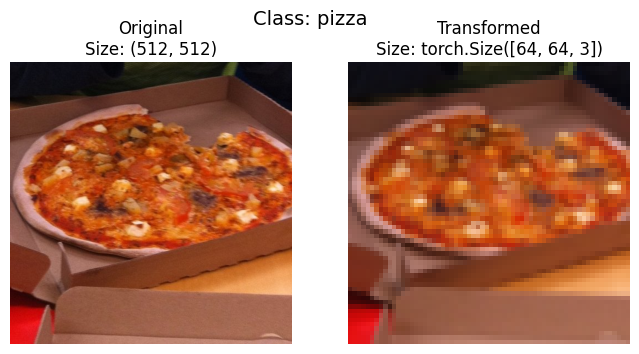

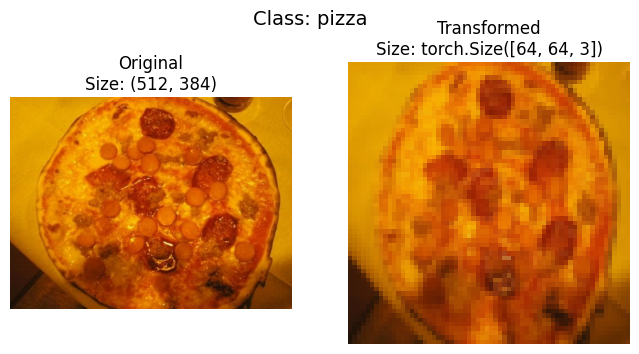

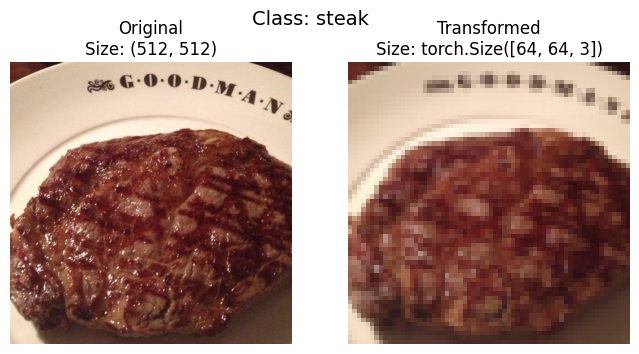

In [14]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Open image
        img = Image.open(image_path)

        # Plot original
        ax[0].imshow(img)
        ax[0].set_title(f"Original\nSize: {img.size}")
        ax[0].axis(False)

        # Transform image
        transformed_image = transform(img).permute(1, 2, 0)  # C,H,W → H,W,C
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
        ax[1].axis(False)

        # Class label (assuming folder name = class name)
        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
        plt.show()

# Example usage:
plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
)
